# Ekhator Uwaila's Notebook

You will be using transfer learning on a large, known dataset called [MSCOCO](https://cocodataset.org/#download). Specifically, you will perform the task of "reference resolution" that identifies objects in images using referring expressions. 



### Download dataset

The mscoco dataset is pretty big (12 GB). We won't be using all of the data, but it makes matters easier to have everything together in one place. To help you download the data, you can run the following script (might need to open the script and follow step by step on windows). You will only need to run this once!

In [27]:
#!bash download_coco.sh

There is an https://github.com/lichengunc/refer/blob/master/refer.py to help you access and use the dataset. The main API is in the refer.py file. Run the following cell to import it, along with some other useful libraries (you may need to run pip to install them)

In [5]:
#pip install scikit-image

In [50]:
from refer import REFER
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import os
from PIL import Image as PImage # pillow
from PIL.Image import Resampling

import os
import clip
import torch

from collections import defaultdict as dd
from tqdm.notebook import tqdm
import random
import operator

### Load the MSOCO dataset with referring expressions, show some stats. 

Notice that the datasets are already split into train, val, and test sets. This is to make it so everyone who uses the dataset can directly compare their results with each other. 

You will train using the `train` set. You will develop your model with the `val` set. After you think you are done, you will perform a final evaluation on the `test` dataset. 

In [29]:
data_root = 'coco'  # contains refclef, refcoco, refcoco+, refcocog and images
dataset = 'refcoco' 
splitBy = 'unc'
refer = REFER(data_root, dataset, splitBy)

loading dataset refcoco into memory...
creating index...
index created.
DONE (t=11.72s)


In [51]:
# print stats about the given dataset
print ('dataset [%s_%s] contains: ' % (dataset, splitBy))
ref_ids = refer.getRefIds()
image_ids = refer.getImgIds()
print ('%s expressions for %s refs in %s images.' % (len(refer.Sents), len(ref_ids), len(image_ids)))

print ('\nAmong them:')
if dataset == 'refclef':
    if splitBy == 'unc':
        splits = ['train', 'val', 'testA', 'testB', 'testC']
    else:
        splits = ['train', 'val', 'test']
elif dataset == 'refcoco':
    splits = ['train', 'val', 'test']
elif dataset == 'refcoco+':
    splits = ['train', 'val', 'test']
elif dataset == 'refcocog':
    splits = ['train', 'val']  # we don't have test split for refcocog right now.
    
for split in splits:
    ref_ids = refer.getRefIds(split=split)
    print ('%s refs are in split [%s].' % (len(ref_ids), split))

dataset [refcoco_unc] contains: 
142210 expressions for 50000 refs in 19994 images.

Among them:
42404 refs are in split [train].
3811 refs are in split [val].
3785 refs are in split [test].


### Example

- run the cells
- each sentence (i.e., referring expression) has an id with images and sub-images associated with it within a dictionary
- there is one object as a sub-image box denoted by the green box outline
- there are three referring expressions for that object

In [72]:
ref_ids = refer.getRefIds()
print(len(ref_ids))
ref_id = 35254 # pick a random ref_id
ref = refer.Refs[ref_id]

ref # a dictionary with all of the needed info for a referring expression+image

50000


{'sent_ids': [100272, 100273, 100274],
 'file_name': 'COCO_train2014_000000173056_1.jpg',
 'ann_id': 275551,
 'ref_id': 35254,
 'image_id': 173056,
 'split': 'train',
 'sentences': [{'tokens': ['white', 'brown', 'sheep', 'right'],
   'raw': 'white brown sheep right',
   'sent_id': 100272,
   'sent': 'white brown sheep right'},
  {'tokens': ['black', 'sheep', 'on', 'right'],
   'raw': 'black sheep on right',
   'sent_id': 100273,
   'sent': 'black sheep on right'},
  {'tokens': ['sheep', 'on', 'the', 'right'],
   'raw': 'sheep on the right',
   'sent_id': 100274,
   'sent': 'sheep on the right'}],
 'category_id': 20}

ref_id [35254] (ann_id [275551])
1. white brown sheep right
2. black sheep on right
3. sheep on the right


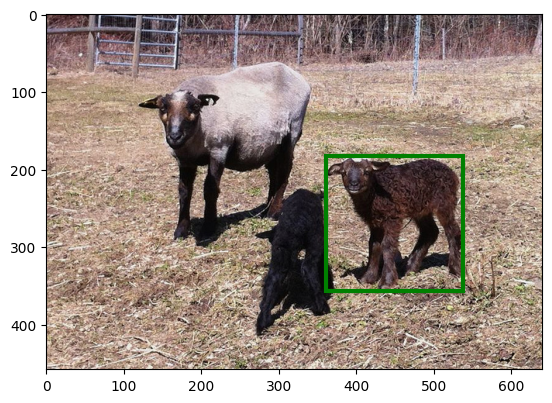

In [73]:
print ('ref_id [%s] (ann_id [%s])' % (ref_id, refer.refToAnn[ref_id]['id']))
# show the segmentation of the referred object
plt.figure()
refer.showRef(ref, seg_box='box')
plt.show()

In [74]:
# words = []
# for i in ref_ids:
#     refthing = refer.Refs[i]
#     for sent in ref['sentences']:
#         words += sent['tokens']
        
# len(list(set(words)))

words = []
for i in ref_ids:
    ref2 = refer.Refs[i]
    for sent in ref2['sentences']:
        words += sent['tokens']
        
len(list(set(words)))

10341

The following function extracts the sub-image (i.e., within a bounding box) from within the image. 

In [81]:
def get_bounded_subimage(img_id, ann_id, xs=224,ys=224, show=False):
    bbox = refer.Anns[ann_id]['bbox']
    bbox = [int(b) for b in bbox]
    img = refer.Imgs[img_id]
    I = io.imread(os.path.join(refer.IMAGE_DIR, img['file_name']))
    sub = I[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
    if show:
        plt.figure()
        ax = plt.gca()
        ax.imshow(sub)
        plt.show()
    if len(sub) == 0: return None
    pim = PImage.fromarray(sub)
    #pim2 = pim.resize((xs,ys), PImage.ANTIALIAS)
    pim2 = pim.resize((xs,ys), Resampling.LANCZOS)
    img = np.array(pim2)
    if len(img.shape) < 3: return None
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    return pim, img
    

### Example sub-image / object

- the following applies the sheep example to the above function
- notice that it extracts the sub-image so you can pass it through a convnet
- it returns a numpy representation of the image

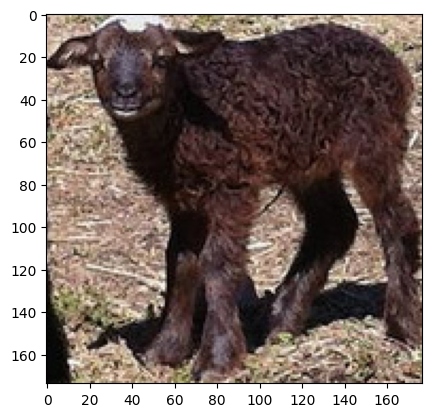

(<PIL.Image.Image image mode=RGB size=177x174>,
 array([[[[201, 175, 155],
          [214, 191, 170],
          [209, 188, 168],
          ...,
          [219, 192, 174],
          [197, 170, 150],
          [184, 157, 135]],
 
         [[197, 172, 151],
          [214, 192, 171],
          [220, 199, 179],
          ...,
          [202, 175, 156],
          [185, 158, 139],
          [182, 155, 136]],
 
         [[170, 145, 128],
          [165, 141, 125],
          [193, 169, 154],
          ...,
          [193, 165, 146],
          [206, 179, 159],
          [224, 198, 178]],
 
         ...,
 
         [[  4,   4,   5],
          [  7,   7,   8],
          [  8,   8,   7],
          ...,
          [115, 104,  98],
          [117, 104,  90],
          [145, 132, 117]],
 
         [[  6,   7,   6],
          [  8,   9,   8],
          [  9,   9,   8],
          ...,
          [228, 209, 195],
          [189, 172, 159],
          [144, 129, 116]],
 
         [[  9,   9,   9],
         

In [82]:
get_bounded_subimage(ref['image_id'], ref['ann_id'], show=True)

The following function `compute_posfeats` is a useful function that extracts a handful of extra features, for example, the area that the subimage takes, the x,y coordinates, among other things. Using this function isn't required, but using it will yield better results. 

In [57]:
def compute_posfeats(img_id, ann_id,):
    img = refer.Imgs[img_id]
    bb = refer.Anns[ann_id]['bbox']
    fname = os.path.join(refer.IMAGE_DIR, img['file_name'])
    if not os.path.isfile(fname): return None
    img = io.imread(fname)
    
    if len(img.shape) < 3: return None
    ih, iw, _ = img.shape
    x,y,w,h = bb
    # x1, relative
    x1r = x / iw
    # y1, relative
    y1r = y / ih
    # x2, relative
    x2r = (x+w) / iw
    # y2, relative
    y2r = (y+h) / ih
    # area
    area = (w*h) / (iw*ih)
    # ratio image sides (= orientation)
    ratio = iw / ih
    # distance from center (normalised)
    cx = iw / 2
    cy = ih / 2
    bcx = x + w / 2
    bcy = y + h / 2
    distance = np.sqrt((bcx-cx)**2 + (bcy-cy)**2) / np.sqrt(cx**2+cy**2)
    # done!
    return np.array([x1r,y1r,x2r,y2r,area,ratio,distance]).reshape(1,7)


In [58]:
# example using the sheep example on the compute_posfeats function
compute_posfeats(ref['image_id'], ref['ann_id']).flatten()

array([0.31997658, 0.20225   , 0.99697892, 0.98201563, 0.52790315,
       0.6671875 , 0.23332303])

# Train

In [59]:
import os
import clip
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load('ViT-B/32', device)

device

'cpu'

In [60]:
from collections import defaultdict as dd
from tqdm import tqdm_notebook as tqdm
import random

In [208]:
words_as_classifiers = dd(list) # use something like this dictionary to store positive examples
train_ids = refer.getRefIds(split='train')

for i in tqdm(train_ids):
    ref = refer.Refs[i]
    # first, get all of the training data
    

    # for a single train_id, you can get its image_id and the ann_id (i.e., the referring expression)
#     ref_id = train_ids[0]
#     ref = refer.Refs[ref_id]
    img_id = ref['image_id']
    ann_id = ref['ann_id']

    try:
        img, _ = get_bounded_subimage(img_id, ann_id, show=False)
        img = preprocess(img).unsqueeze(0).to(device)
        enc_img = clip_model.encode_image(img)
        pos_feats = compute_posfeats(img_id, ann_id)
        feature_vector = np.concatenate((enc_img.detach().numpy(), pos_feats), axis=1)
        #then you'll need to get the bounded subimage by calling the get_bounded_subimage function.

        #then, you'll need to pass that image through a convnet like you did for A6

        #optionally, you can call the compute_posfeats function to get some additional features
        #concatenate these to the convnet output to form a single vector for this image

        #add this feature vector to a list of positive examples for each word in the referring expression
        # you may need to flatten() the feature vector
        for sent in ref['sentences']:
            for word in sent['tokens']:
                words_as_classifiers[word].append(feature_vector)
    except:
        continue

    # once you have all of the positive examples for all of the words, you'll need to find negative examples for each word
    # the number of negative examples should be a function of how many positive examples there are

# finally, train a binary classifier for each word
for word in words_as_classifiers:
    print(word, len(words_as_classifiers[word]))

/var/folders/3t/lfj_tnbd7fd1t5jjhk9_0zmw0000gq/T/ipykernel_22260/1176684297.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(train_ids):


  0%|          | 0/42404 [00:00<?, ?it/s]

the 15910
lady 2149
with 6162
blue 4706
shirt 7586
back 3564
to 3978
us 1059
woman 5489
in 17336
gray 996
facing 575
camera 432
on 21753
right 27491
greyshirt 1
person 6131
standing 1225
u 26
middle 5577
up 649
sitting 1098
girl 5219
floor 86
left 27813
under 533
suitcase 584
man 9214
jacket 884
trying 15
help 4
most 663
toilet 314
far 4310
urinal 89
stall 2
vase 624
center 2420
bus 1369
buss 9
red 4462
front 6770
whole 166
head 1160
just 336
behind 1573
leftin 1
no 289
cap 159
brown 1383
hair 582
coming 33
out 377
of 6708
girls 91
chin 20
kid 2205
player 1233
boy 1826
looking 529
at 1504
you 456
bird 405
second 3051
laptop 609
from 3406
above 532
cellphone 16
nearest 188
monitor 385
hand 1014
bottom 5996
fronnt 2
upper 693
corner 1731
top 5352
image 106
white 6447
hat 971
dude 870
guy 9577
bald 180
half 598
what 61
are 78
these 6
foods 1
thing 615
chicken 50
food 819
onions 14
carrots 142
side 1834
onion 10
cow 1429
leftmost 299
animal 611
edge 370
pic 535
lying 52
down 551
laying 188

In [209]:
def find_negative_samples(words_as_classifiers, word):
    words = list(words_as_classifiers.keys())
    words.remove(word)
    random_word = random.choice(words)
    random_vector = random.choice(words_as_classifiers[random_word])
    return random_vector
    
find_negative_samples(words_as_classifiers,'shirt')

array([[-1.01303399e-01,  4.38041836e-01,  3.58267650e-02,
         2.31595337e-01, -2.97090560e-02, -3.87835987e-02,
         1.13240920e-01,  2.98270643e-01,  5.04100859e-01,
         1.40052199e-01,  3.73555124e-01, -1.74340993e-01,
         2.20961958e-01, -1.74267203e-01,  2.11159676e-01,
        -3.87121253e-02, -5.50873756e-01,  7.09942877e-02,
         1.69083476e-02, -6.07306957e-01,  3.85698020e-01,
         2.45086610e-01,  1.15085222e-01, -1.90815285e-01,
        -1.78612649e-01, -2.20371574e-01,  1.86602712e-01,
         2.68848240e-01,  2.87554264e-02,  3.04831415e-02,
         4.01449203e-01,  3.62824649e-01, -7.32211396e-02,
        -3.57560933e-01, -1.66508347e-01, -3.03889364e-01,
         2.12623507e-01, -1.66555375e-01,  1.28974304e-01,
        -8.31699744e-02,  2.26507530e-01,  9.93611515e-02,
        -2.47370496e-01,  3.30732018e-02,  3.25561851e-01,
        -2.23870873e+00, -2.48462260e-02, -7.17319250e-02,
         3.51912379e-02,  2.30046242e-01,  3.09844643e-0

In [210]:
num_negatives = 2 
threshold = 4

wac = {}

for word in tqdm(words_as_classifiers):
    pos_vectors = words_as_classifiers[word]
    num_pos_vectors = len(pos_vectors)
    if num_pos_vectors < threshold:
        continue
#     print(word, num_pos_vectors)
    neg_vectors = []
    for i in range(0,num_negatives*num_pos_vectors):
        neg_vectors.append(find_negative_samples(words_as_classifiers,word))
    neg_vectors = np.array(neg_vectors)
    pos_vectors = np.array(pos_vectors)
    neg_vectors = neg_vectors.reshape(neg_vectors.shape[0], neg_vectors.shape[2])
    pos_vectors = pos_vectors.reshape(pos_vectors.shape[0], pos_vectors.shape[2])
#     print(pos_vectors.shape, neg_vectors.shape)
    X = np.concatenate((pos_vectors, neg_vectors), axis=0)
    
    y = np.concatenate((np.ones(num_pos_vectors), np.zeros(len(neg_vectors))))
    wac[word] = (X,y)
    

/var/folders/3t/lfj_tnbd7fd1t5jjhk9_0zmw0000gq/T/ipykernel_22260/3559442937.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for word in tqdm(words_as_classifiers):


  0%|          | 0/9350 [00:00<?, ?it/s]

In [211]:
wac['the'][0].shape

(47730, 519)

# Validate

In [65]:
from sklearn.linear_model import LogisticRegression

In [212]:
for word in wac:
    clfr = LogisticRegression()
    X,y = wac[word]
    clfr.fit(X,y)
    wac[word] = clfr

/Users/uwailaekhator/anaconda3/envs/NLP/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/uwailaekhator/anaconda3/envs/NLP/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

In [213]:
wac

{'the': LogisticRegression(),
 'lady': LogisticRegression(),
 'with': LogisticRegression(),
 'blue': LogisticRegression(),
 'shirt': LogisticRegression(),
 'back': LogisticRegression(),
 'to': LogisticRegression(),
 'us': LogisticRegression(),
 'woman': LogisticRegression(),
 'in': LogisticRegression(),
 'gray': LogisticRegression(),
 'facing': LogisticRegression(),
 'camera': LogisticRegression(),
 'on': LogisticRegression(),
 'right': LogisticRegression(),
 'person': LogisticRegression(),
 'standing': LogisticRegression(),
 'u': LogisticRegression(),
 'middle': LogisticRegression(),
 'up': LogisticRegression(),
 'sitting': LogisticRegression(),
 'girl': LogisticRegression(),
 'floor': LogisticRegression(),
 'left': LogisticRegression(),
 'under': LogisticRegression(),
 'suitcase': LogisticRegression(),
 'man': LogisticRegression(),
 'jacket': LogisticRegression(),
 'trying': LogisticRegression(),
 'help': LogisticRegression(),
 'most': LogisticRegression(),
 'toilet': LogisticRegress

In [214]:
eval_ids = refer.getRefIds(split='val')

In [215]:
eval_ids

[77,
 78,
 85,
 86,
 101,
 102,
 151,
 177,
 178,
 179,
 180,
 198,
 199,
 215,
 216,
 276,
 277,
 278,
 279,
 280,
 281,
 395,
 396,
 397,
 398,
 412,
 413,
 465,
 466,
 492,
 493,
 571,
 572,
 610,
 611,
 633,
 634,
 681,
 682,
 683,
 684,
 717,
 718,
 745,
 746,
 747,
 748,
 768,
 769,
 770,
 780,
 781,
 785,
 786,
 787,
 788,
 789,
 790,
 791,
 792,
 793,
 927,
 928,
 960,
 961,
 962,
 1040,
 1041,
 1056,
 1057,
 1109,
 1110,
 1175,
 1176,
 1177,
 1178,
 1203,
 1204,
 1233,
 1234,
 1254,
 1255,
 1304,
 1305,
 1306,
 1307,
 1350,
 1351,
 1383,
 1384,
 1428,
 1429,
 1434,
 1435,
 1436,
 1460,
 1461,
 1492,
 1493,
 1494,
 1495,
 1553,
 1554,
 1555,
 1596,
 1597,
 1625,
 1641,
 1642,
 1643,
 1650,
 1651,
 1652,
 1757,
 1758,
 1799,
 1800,
 1801,
 1802,
 1803,
 1804,
 1807,
 1808,
 1853,
 1854,
 1859,
 1860,
 1925,
 1926,
 1958,
 1959,
 1960,
 1967,
 1968,
 1969,
 1970,
 2003,
 2004,
 2020,
 2021,
 2035,
 2036,
 2037,
 2038,
 2134,
 2135,
 2183,
 2184,
 2185,
 2186,
 2199,
 2200,
 2201,

In [216]:
len(eval_ids)

3811

In [18]:
# step through the eval ids
# get all of the objects as feature vectors for an image using your convnet
# for each object,
# for each referring expression / sentence
# apply all of the feature vectors to your trained classifiers for each word in the sentence
# multiply the classifier probabilities together for each word
# e.g., for the last sentence above: Pblue(object1) * Pshirt(object1)
# find the object with the highest resulting multiplied probability, compare to gold, compute accuracy

In [219]:
def evaluate(eval_ids, wac, refer):
    total_correct = 0
    total_evaluated = 0

    for i in tqdm(eval_ids):
        ref = refer.Refs[i] #get all evaluation data
        img_id = ref['image_id']
        ann_id = ref['ann_id']#gold annotation id for the sentences
        objs = refer.imgToAnns[img_id]
        ann_ids = [item['id'] for item in objs]
        
        objects_and_features = {} #dictionary to store object and feature vectors
        
        for obj in ann_ids:
            try:
                img, _ = get_bounded_subimage(img_id, obj, show=False)
                img = preprocess(img).unsqueeze(0).to(device)
                enc_img = clip_model.encode_image(img)
                pos_feats = compute_posfeats(img_id, obj)
                feature_vector = np.concatenate((enc_img.cpu().detach().numpy(), pos_feats), axis=1)
                objects_and_features[obj] = feature_vector # Store obj and feature_vector in the dictionary
            except:
                continue
        # evaluate each sentence
        for sent in ref['sentences']:
            sentence_probs = {}
            for word in sent['tokens']:
                if word in wac:
                    for obj_id, feature_vector in objects_and_features.items():
                        word_prob = clfr.predict_proba(feature_vector)[0][1] # Get probability of being the correct object
                        
                        if obj_id not in sentence_probs:
                            sentence_probs[obj_id] = obj_id
                        else:
                            sentence_probs[obj_id] *= word_prob
            if not sentence_probs:
                continue
                
            predicted_obj_id = max(sentence_probs, key=sentence_probs.get)
            total_correct += (predicted_obj_id == ann_id)


    accuracy = total_correct / len(eval_ids)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Total correct: {total_correct}")
    print(f"Total evaluated: {len(eval_ids)}")



In [220]:
evaluate(eval_ids[:5], wac, refer)

/var/folders/3t/lfj_tnbd7fd1t5jjhk9_0zmw0000gq/T/ipykernel_22260/3594847851.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(eval_ids):


  0%|          | 0/5 [00:00<?, ?it/s]

Accuracy: 0.6000
Total correct: 3
Total evaluated: 5


In [205]:
evaluate(eval_ids[:100], wac, refer)

/var/folders/3t/lfj_tnbd7fd1t5jjhk9_0zmw0000gq/T/ipykernel_22260/2931357294.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(eval_ids):


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy: 0.4200
Total correct: 42
Total evaluated: 100


In [221]:
evaluate(eval_ids, wac, refer)

/var/folders/3t/lfj_tnbd7fd1t5jjhk9_0zmw0000gq/T/ipykernel_22260/3594847851.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(eval_ids):


  0%|          | 0/3811 [00:00<?, ?it/s]

Accuracy: 0.4539
Total correct: 1730
Total evaluated: 3811


# Evaluate

- perform evaluation on the final test set **after** you're done developing and improving your model
- (you can run the cell below, then run the evaluation code you wrote as this overrides the `eval_ids` variable with the held out test set


In [222]:
eval_ids_test = refer.getRefIds(split='test')

In [223]:
len(eval_ids_test)

3785

In [224]:
eval_ids_test

[25,
 26,
 27,
 28,
 45,
 46,
 47,
 109,
 110,
 111,
 112,
 164,
 165,
 166,
 232,
 233,
 234,
 235,
 259,
 260,
 261,
 262,
 285,
 286,
 287,
 288,
 299,
 300,
 326,
 327,
 328,
 360,
 361,
 362,
 363,
 364,
 382,
 383,
 435,
 436,
 474,
 475,
 519,
 520,
 525,
 526,
 527,
 528,
 537,
 538,
 539,
 545,
 557,
 558,
 588,
 589,
 605,
 629,
 630,
 640,
 641,
 668,
 669,
 677,
 678,
 721,
 722,
 732,
 733,
 734,
 756,
 757,
 814,
 815,
 828,
 829,
 837,
 838,
 855,
 856,
 923,
 924,
 925,
 926,
 931,
 932,
 933,
 940,
 941,
 945,
 946,
 947,
 954,
 955,
 956,
 1023,
 1024,
 1052,
 1053,
 1152,
 1153,
 1154,
 1155,
 1156,
 1218,
 1219,
 1227,
 1228,
 1256,
 1257,
 1273,
 1274,
 1283,
 1333,
 1334,
 1339,
 1340,
 1362,
 1363,
 1368,
 1371,
 1372,
 1406,
 1407,
 1568,
 1569,
 1582,
 1583,
 1623,
 1624,
 1644,
 1645,
 1679,
 1680,
 1681,
 1682,
 1683,
 1684,
 1776,
 1777,
 1811,
 1812,
 1861,
 1862,
 1865,
 1866,
 1867,
 1868,
 1869,
 1870,
 1871,
 1882,
 1883,
 1977,
 1978,
 1979,
 1980,
 19

In [225]:
evaluate(eval_ids_test, wac, refer)

/var/folders/3t/lfj_tnbd7fd1t5jjhk9_0zmw0000gq/T/ipykernel_22260/3594847851.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(eval_ids):


  0%|          | 0/3785 [00:00<?, ?it/s]

Accuracy: 0.4346
Total correct: 1645
Total evaluated: 3785


# Questions

- (answer the following below as a markdown cell)
- How well does your model perform on the test set (using the accuracy metric)? <br>
  My model produced an accuracy score of 43.5% percent, it performs well.
  <br> <br> <br>
- Is that a good score? How do you know? <br>
  I think its a good score because it is higher than the random baseline. The random baseline can be calculated as:
  probability of guessing the correct object using the referrent expressions which is 1/3 * 1/3, since we have 3 objects and 3 expressions. This gives 1/9 = 0.111, that is approximately 11%
  <br><br><br>
- What assumptions does your model make? Hint: what would happen if the sentences/referring expressions had a different word order? Would it make a difference? <br>
  I dont think that changing the word order of the referrent expression would make a difference. The model does not consider the order of the words, it just checks that the words are present and then calculates a probability.
   <br> <br> <br>
- What could you do to improve the model?
  I could use a language model that considers the suntatic structure of sentences, for example a pretrained model like BERT

-------------------------END------------------------------------

<!-- ## note

for a particular image and its 3 ref expression, step through each sentence with the 3 objects in the image and get the argmax prob, then check if the ann_id of the argmax matches the actual ann_id that the sentence refers to, and increase ur accuracy score

use a loop to step thru objects inimage, get the vector rep of the objects and store in a dic(obj id and vector), then step thru each sentence, apply classifier for 'the' and 'dude' to each object. check which has a higher prob, if it matches the ann_id u get an accuracy score -->

In [ ]:
# from sklearn.metrics import accuracy_score

# def evaluate(eval_ids, wac, refer):
#     total_correct = 0
#     total_evaluated = 0

#     for i in tqdm(eval_ids):
#         ref = refer.Refs[i] #get all evaluation data
#         img_id = ref['image_id']
#         ann_id = ref['ann_id']#gold annotation id for the sentences
#         objs = refer.imgToAnns[img_id]
#         ann_ids = [item['id'] for item in objs]
        
#         # Assuming `get_bounded_subimage` can somehow be adapted to return all objects in the image
#         # Here, we'll need to preprocess each object similarly to training, and compute feature vectors
#         #objects_and_features = []  # This will store tuples of (obj_id, feature_vector)
#         objects_and_features = {}
        
#         #for obj in refer.getAnnIds(img_id):
#         for obj in ann_ids:
#             img, _ = get_bounded_subimage(img_id, obj, show=False)
#             img = preprocess(img).unsqueeze(0).to(device)
#             enc_img = clip_model.encode_image(img)
#             pos_feats = compute_posfeats(img_id, obj)
#             #feature_vector = np.concatenate((enc_img.cpu().detach().numpy().flatten(), pos_feats.flatten()), axis=0)
#             feature_vector = np.concatenate((enc_img.cpu().detach().numpy(), pos_feats), axis=1)
#             #objects_and_features.append((obj, feature_vector))
#             objects_and_features[obj] = feature_vector # Store obj and feature_vector in the dictionary

#         # Now, evaluate each sentence
#         for sent in ref['sentences']:
#             #sentence_probs = {obj_id: 1 for obj_id in objects_and_features.keys()}
#             sentence_probs = {}
#             for word in sent['tokens']:
#                 if word in wac:
#                     #classifier = wac[word]
#                     for obj_id, feature_vector in objects_and_features.items():
#                         #feature_vector_2d = feature_vector.reshape(1, -1)
#                         #word_prob = clfr.predict_proba(feature_vector_2d)[0][1]  # Get probability of being the correct object
#                         word_prob = clfr.predict_proba(feature_vector)[0][1]
                        
#                         if obj_id not in sentence_probs:
#                             sentence_probs[obj_id] = obj_id
#                         else:
#                             sentence_probs[obj_id] *= word_prob
#             if not sentence_probs:
#                 continue
#             predicted_obj_id = max(sentence_probs, key=sentence_probs.get)
#             total_correct += (predicted_obj_id == ann_id)
#             total_evaluated += 1

#     accuracy = total_correct / total_evaluated
#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Total evaluated: {total_evaluated}")
#     print(f"Total correct: {total_correct}")

